In [1]:
import pickle
import re
import sys
from datetime import datetime, timedelta
from importlib import reload
from pathlib import Path

import get_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import talib
import tensorflow as tf
import wandb
import yfinance as yf
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from tools import inspect_code, plotting, training, wandb_api
from tools.training import Datapoint
from tqdm import tqdm
import utils
from wandb.keras import WandbCallback


repo_path = Path().resolve().parent
log_wandb = True
tf.config.list_physical_devices("CPU")[0].device_type


2022-05-02 00:00:08.390167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 00:00:08.390208: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-02 00:00:11.682806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory


'CPU'

2022-05-02 00:00:11.683425: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-02 00:00:11.683450: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Matias): /proc/driver/nvidia/version does not exist


In [6]:
wandb_api.login()
api = wandb.Api()
run_name = "1gqaeid3"
run = api.run(f"matiasetcheverry/crypto-prediction/{run_name}")
config = run.config

root_path = Path("tmp")
model = run.file("rf.pkl")
model = model.download(root=root_path / run.name, replace=True)
with open(model.name, "rb") as file:
    rf = pickle.load(file)
config

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


{'interval': '1d',
 'job_type': 'test',
 'max_depth': 17,
 'n_estimator': 2000,
 'train_val_test_split': [0.7, 0.15, 0.15]}

In [26]:
config["train_val_test_split"] = [0, 0, 1]
df = pd.read_csv(repo_path / "DATE.csv", delimiter=";")
df["beginning_date"] = pd.to_datetime(df.pop("beginning_date"), dayfirst=True, utc=True)
df["ending_date"] = pd.to_datetime(df.pop("ending_date"), dayfirst=True, utc=True)
inputs = [
    {
        "ticker": ticker,
        "beginning_date": datetime.today() - timedelta(days=400),
        "ending_date": datetime.today(),
    }
    for ticker in df["ticker"].unique()
    if ticker != "FLOKI"
]

dm = utils.DataModule(
    config=config,
    compute_metrics=utils._concatenate_indicators,
    inputs=inputs,
)
dm.setup()
test_datapoints = dm.test_datapoints


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

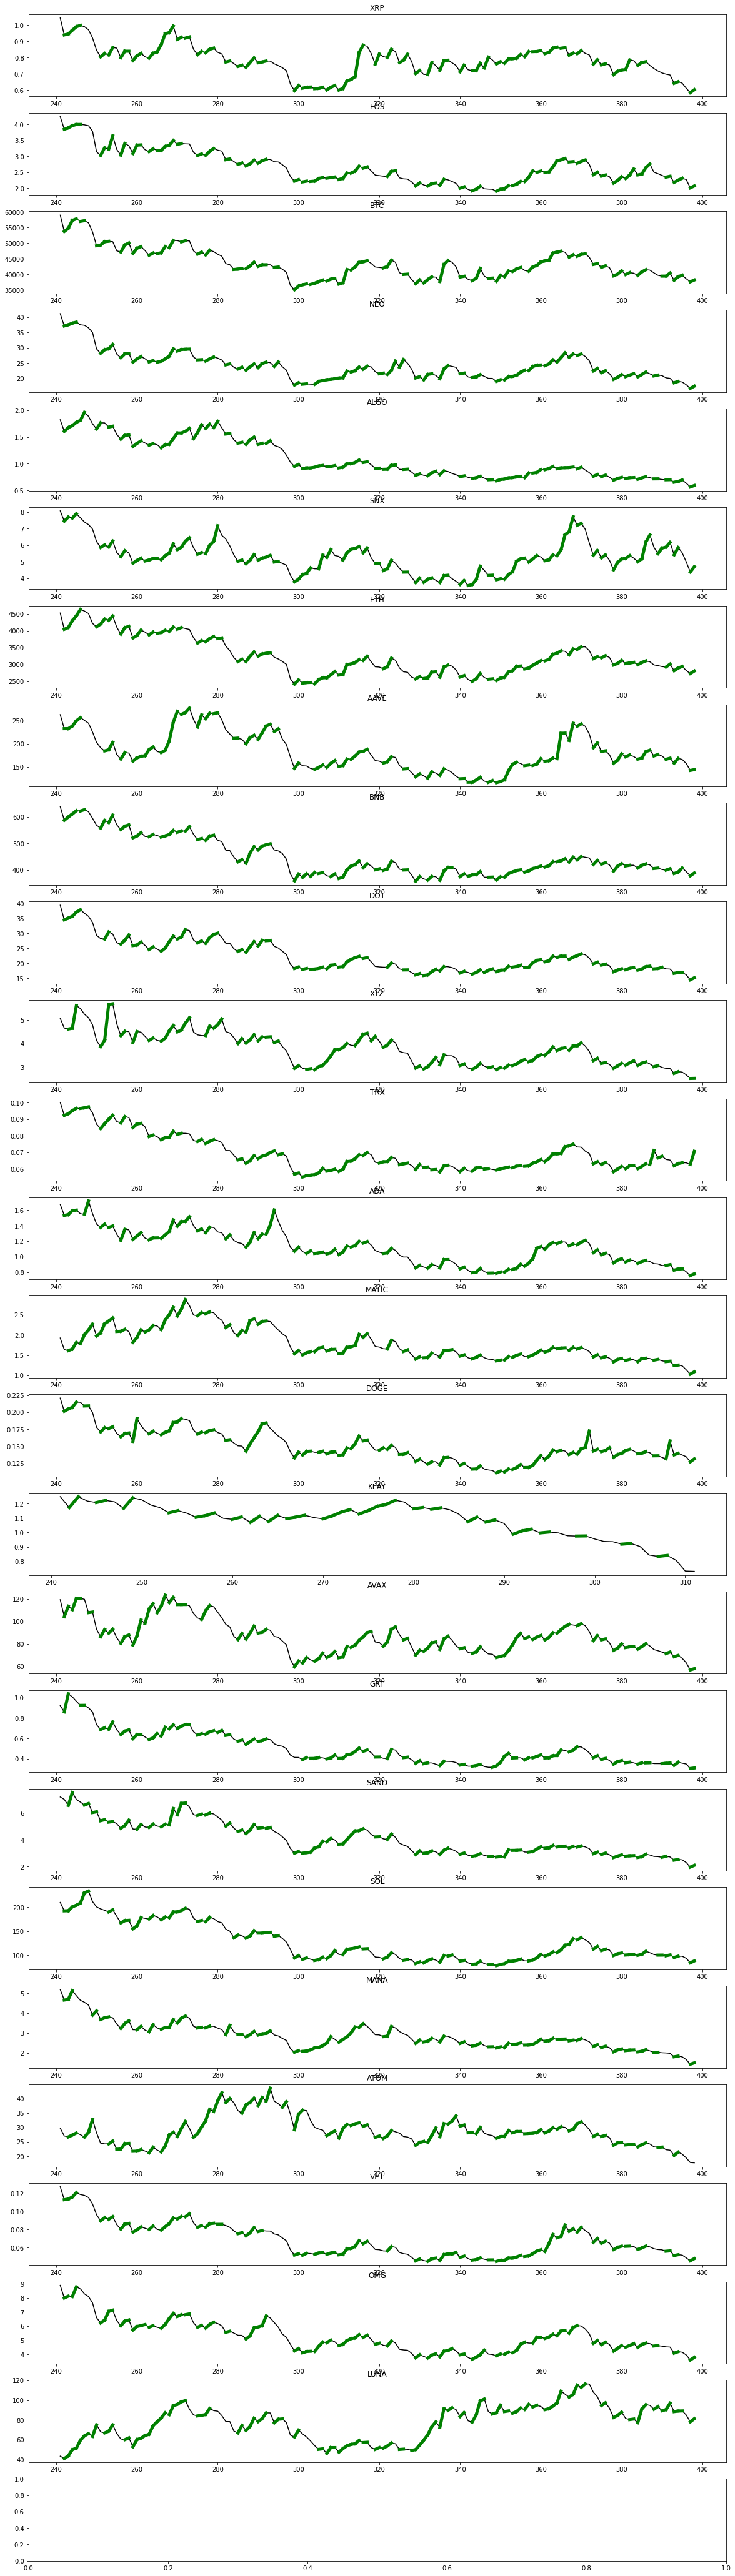

In [27]:
m = len(test_datapoints)
plot = True

if plot:
    fig, axs = plt.subplots(m + 1, figsize=(20, 3 * m))

tf.config.run_functions_eagerly(True)
for index, dp in enumerate(test_datapoints[:m]):
    last_n_points = 0

    features = dp.features[-last_n_points:, :]
    predictions = dp.predict_from(rf)[-last_n_points:]
    labels = dp.labels[-last_n_points:]
    df = dp.df[-last_n_points:]

    test_datapoints[index].recall = recall_score(
        labels,
        predictions.reshape(-1, 1),
    )
    test_datapoints[index].precision = precision_score(
        labels,
        predictions.reshape(-1, 1),
        zero_division=0,
    )
    test_datapoints[index].accuracy = accuracy_score(
        labels,
        predictions.reshape(-1, 1),
    )

    if plot:
        close_idx = 3
        df["Close"].plot(color="black", ax=axs[index])
        color = np.array(["red", "green"])[
            ((df["Open"] < df["Close"]).astype(np.int32).to_numpy())
        ]

        for idx, up in enumerate(predictions):
            if up and idx > 0:
                axs[index].plot(
                    df.index[idx - 1 : idx + 1],
                    df["Close"][idx - 1 : idx + 1],
                    color=color[idx],
                    linewidth=5,
                )
        axs[index].set_title(dp.ticker)
plt.show()


In [24]:
for dp in test_datapoints:
    if dp.ticker in ["ETH", "BTC", "BNB", "LTC", "XRP", "TRX"]:
        print(dp.ticker, dp.predict_proba_last_from(rf))


XRP 0.9260997181561889
BTC 0.9278635072397218
ETH 0.9133577504161715
BNB 0.9198062824549633
TRX 0.9296032410638999


In [28]:
test_datapoints.sort(key=lambda x: x.precision, reverse=True)
for dp in test_datapoints:
    print(dp.ticker, "\t", dp.precision, "\t", dp.recall)


XRP 	 1.0 	 1.0
EOS 	 1.0 	 1.0
BTC 	 1.0 	 1.0
NEO 	 1.0 	 1.0
ALGO 	 1.0 	 1.0
SNX 	 1.0 	 1.0
ETH 	 1.0 	 1.0
AAVE 	 1.0 	 1.0
BNB 	 1.0 	 1.0
DOT 	 1.0 	 1.0
XTZ 	 1.0 	 1.0
TRX 	 1.0 	 1.0
ADA 	 1.0 	 1.0
MATIC 	 1.0 	 1.0
DOGE 	 1.0 	 1.0
KLAY 	 1.0 	 1.0
AVAX 	 1.0 	 1.0
GRT 	 1.0 	 1.0
SAND 	 1.0 	 1.0
SOL 	 1.0 	 1.0
MANA 	 1.0 	 1.0
ATOM 	 1.0 	 1.0
VET 	 1.0 	 1.0
OMG 	 1.0 	 1.0
LUNA 	 1.0 	 1.0


In [76]:
import vectorbt as vbt

reload(get_data)
from datetime import datetime, timedelta
import vectorbt as vbt

vbt.settings.portfolio["fees"] = 0.001
vbt.settings.portfolio["slippage"] = 0.0025
data = vbt.Data.from_data(
    {dp.ticker: dp.df.drop(labels="Direction", axis=1) for dp in dm.test_datapoints},
    download_kwargs={},
)


/home/matias/.pyenv/versions/3.9.8/envs/binance/lib/python3.9/site-packages/vectorbt/data/base.py:527: UserWarning:

Symbols have mismatching index. Setting missing data points to NaN.



In [81]:
def apply_rf(*args, **kwargs):
    proba = kwargs["proba"]
    price = np.squeeze(np.stack(args[1:], axis=1))
    length = price.shape[0]
    try:
        probabilities = rf.predict_proba(price)
        direction = np.argmax(probabilities > proba, axis=1)
    except ValueError:
        direction = np.zeros(length)
    return direction


def plot_trix(trix, signal, column=None, fig=None):
    fig = trix.vbt.plot(fig=fig)
    fig = signal.vbt.plot(fig=fig)


RF = vbt.IndicatorFactory(
    input_names=list(data.data.values())[0].columns[6:],
    output_names=["direction"],
    # subplots=dict(
    #     plot_outputs=dict(
    #         plot_func=plot_trix,
    #         resolve_trix=True,
    #         resolve_signal=True,
    #     )
    # ),
).from_apply_func(
    apply_rf,
    proba=0.5,
)
direction = RF.run(
    *data.get()[6:],
    run_unique=True,
    short_name="entries",
    per_column=True,
    pass_col=True
)
trend_ma = vbt.MA.run(data.get("Close"), window=50, ewm=True, run_unique=True)

ohlcstcx = vbt.OHLCSTCX.run(
    entries=direction.direction_above(0.5),
    open=data.get("Open"),
    high=data.get("High"),
    low=data.get("Low"),
    close=data.get("Close"),
    sl_stop=0.2,
    sl_trail=False,
    tp_stop=0.3,
)

exits = direction.direction.shift(1).astype("bool") | ohlcstcx.exits
entries = direction.direction


In [82]:
pf = vbt.Portfolio.from_signals(
    data.get("Open"),
    entries=entries,
    exits=exits,
    freq=timedelta(days=1),
)
total_return = pf.total_return()
total_return, total_return[total_return != 0].mean(), total_return[
    total_return != 0
].median()
# for idx, p in enumerate(pf):
#     print(p.returns_stats())
# pf.loc[total_return.idxmax()].plot()
# for p in pf:
#     print(p.returns_stats())
#     print("---------------------------------")


(ohlcstcx_sl_stop  ohlcstcx_sl_trail  ohlcstcx_tp_stop  symbol
 0.2               False              0.3               MANA      138.172444
                                                        MATIC      28.934842
                                                        BNB        18.939538
                                                        SNX        43.624088
                                                        XTZ        20.223858
                                                        TRX        13.699306
                                                        NEO        12.397220
                                                        DOGE        4.094612
                                                        VET        15.889708
                                                        ADA        15.831990
                                                        AVAX        0.000000
                                                        EOS        12.117722
             

In [84]:
# for p in pf:
#     print(p.returns_stats())
#     print("---------------------------------")
pf.iloc[2].plots()


FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'na…